***
## Experimentation

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_style('whitegrid')
sns.set_context('talk')

### 5.1

In [16]:
delta = 0.05
def bound1(t, delta, sigma2):
    return np.sqrt(2*np.log(2/delta)/t)

def bound2(t, delta, sigma2):
    return np.sqrt(1+1/(t*sigma2))*np.sqrt((2*np.log(1/delta)+np.log(t*sigma2+1))/t)

In [68]:
ts = np.linspace(1,10000000, 1000).reshape(-1,1)
sigma2s = np.logspace(-6,0,7).reshape(1,-1)

In [69]:
b1 = bound1(ts, delta, sigma2s)
b2 = bound2(ts, delta, sigma2s)
ratio = b2/b1

In [70]:
df = pd.DataFrame({'t': ts.reshape(-1)}, index=None)
df[sigma2s.reshape(-1).astype(str)] = ratio

In [71]:
df.idxmin()

t           0
1e-06     820
1e-05      82
0.0001      8
0.001       1
0.01        1
0.1         1
1.0         0
dtype: int64

In [75]:
df

,t,1e-06,1e-05,0.0001,0.001,0.01,0.1,1.0
0,1.000000e+00,901.165425,284.975026,90.121748,28.513959,9.064112,3.012505,1.346142
1,1.001101e+04,9.059185,3.011023,1.345827,1.118414,1.205053,1.323036,1.435569
2,2.002102e+04,6.442924,2.239780,1.200478,1.134053,1.240448,1.357746,1.467889
3,3.003103e+04,5.290711,1.915832,1.154612,1.149013,1.261378,1.377722,1.486478
4,4.004104e+04,4.607816,1.732024,1.134761,1.161222,1.276217,1.391744,1.499530
...,...,...,...,...,...,...,...,...
995,9.959960e+06,1.118365,1.204796,1.322777,1.435328,1.540153,1.638336,1.730966
996,9.969970e+06,1.118374,1.204847,1.322828,1.435376,1.540197,1.638378,1.731005
997,9.979980e+06,1.118384,1.204897,1.322879,1.435423,1.540241,1.638419,1.731044
998,9.989990e+06,1.118394,1.204947,1.322930,1.435470,1.540285,1.638461,1.731083


In [72]:
df_ = df.melt(id_vars=['t'], value_vars=df.columns[1:], value_name='bound ratio', var_name='sigma')

In [79]:
df_['b2'] = b2.flatten(order='F')

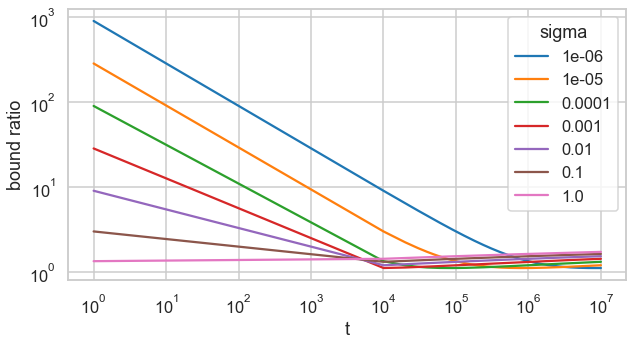

In [74]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_, x='t', y='bound ratio', hue='sigma', ax =ax)
ax.set_yscale('log')
ax.set_xscale('log')

We see that for this delta, the smaller the sigma, the more time it takes for bound (1) to be at its minimum with respect to bound (3). If the absolute value of the mean is about 0.01, to be sure if it is positive or negative we would need a confidence bound of 0.01. The question is, at what time will we have this confidence? 

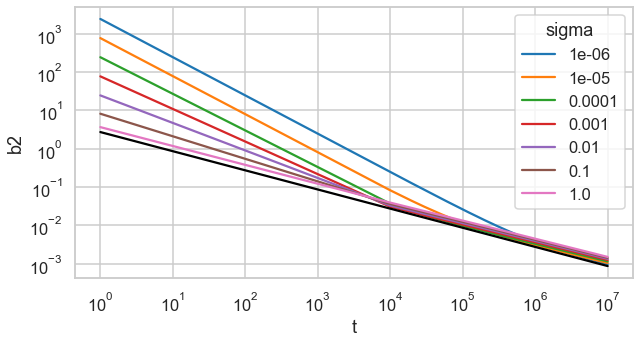

In [81]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_, x='t', y='b2', hue='sigma', ax =ax)
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(ts, b1, c='k')

## 5.2

In [326]:
class FrankWolfe:
    """
    Attributes
    ----------
    X : (n, d) matrix of arms
    XXT : (n, d, d) matrix of self interaction
    lamb : (n,1) vector of arm distribution
    A : (d, d) matrix of weighted self interactions
    """
    def __init__(self, d: int, a: float, n: int, N: int):
        self.d = d
        self.a = a
        self.n = n
        self.N = N
        self.startup()
        return
    
    @staticmethod
    def sample_X(d: int, a: float, n: int):
        def sample_xi(d: int, a: float):
            sigma2s = [j**(-a) for j in range(1,d+1)]
            return np.array(np.random.normal(0, np.sqrt(sigma2s))).reshape(1,-1)
        return np.concatenate([sample_xi(d, a) for i in range(n)])
    
    def startup(self):
        # get our arms
        self.X = self.sample_X(self.d, self.a, self.n)
        # pull first 2d arms and set lambda
        pulls = np.random.choice(list(range(self.n)), size=(2*self.d))
        values, counts_ = np.unique(pulls, return_counts=True)
        counts = []
        for i in range(self.n):
            if i in values:
                counts.append(counts_[np.argwhere(values==i)][0][0])
            else:
                counts.append(0)
        self.lamb = (np.array(counts)/(2*self.d)).reshape(-1,1)
        # start time after startup
        self.t = 2*self.d
        # the raw XXT matrix
        xs = []
        for x in self.X:
            xs.append(np.matmul(x.reshape(-1,1), x.reshape(1,-1)))
        self.XXT = np.array(xs)
        return
    
    @property
    def A(self):
        """Function of current lambda"""
        return np.sum(self.lamb.reshape(-1,1,1)*self.XXT, axis=0)
    
    @property
    def D_lamb(self):
        return -np.log(np.linalg.det(self.A))
        
    def update_for_next(self, arm_index):
        """Update lambda and time at the end of the iteration."""
        indicator = np.zeros((self.n,1))
        indicator[arm_index] = 1
        # at this lambda and t are both at their end of previous iteration state, eg t has not been updated
        self.lamb = (self.lamb*self.t + indicator)/(self.t+1)
        self.t += 1
        return
    
    def g_prime_i(self, i):
        """Compute gradient of design equation for one example's lambda"""
        return -np.matmul(np.matmul(self.X[i].reshape(1,-1), np.linalg.inv(self.A)),  self.X[i].reshape(-1,1))
    
    def take_step(self):
        # get the gradient vector
        self.g_prime = np.concatenate([self.g_prime_i(i) for i in range(self.n)])
        It = np.argmin(self.g_prime)
        self.update_for_next(It)
        print(f'Time {self.t}, pull {It}, D = {self.D_lamb}')
        return 
    
    def run(self):
        while self.t < self.N:
            self.take_step()
        return self.lamb, self.D_lamb
        
    
    

In [327]:
test = FrankWolfe(10, .5, 100, 1000)

In [328]:
lamb, D = test.run()

Time 21, pull 28, D = 11.181520285832365
Time 22, pull 71, D = 10.456639086336335
Time 23, pull 69, D = 9.810635329694552
Time 24, pull 68, D = 9.352111685156196
Time 25, pull 41, D = 8.948672599121924
Time 26, pull 76, D = 8.576843545892396
Time 27, pull 77, D = 8.260887390819923
Time 28, pull 96, D = 7.971501066722565
Time 29, pull 7, D = 7.75929654326972
Time 30, pull 48, D = 7.550530592146859
Time 31, pull 18, D = 7.362781131979865
Time 32, pull 95, D = 7.2039576560512355
Time 33, pull 0, D = 7.091169340345169
Time 34, pull 69, D = 6.9743962749110295
Time 35, pull 28, D = 6.872950109189974
Time 36, pull 41, D = 6.7659479627756935
Time 37, pull 92, D = 6.668265834170393
Time 38, pull 43, D = 6.578147587466669
Time 39, pull 77, D = 6.483380815869372
Time 40, pull 7, D = 6.40316434415684
Time 41, pull 76, D = 6.3250787966699
Time 42, pull 52, D = 6.2449140023716385
Time 43, pull 18, D = 6.17789318859881
Time 44, pull 49, D = 6.128871280452978
Time 45, pull 41, D = 6.078409692680145
Ti

In [322]:
D

4.741119176805726

In [309]:
np.hstack(g_primes)[42]

array([3.72326519, 3.29586034, 2.9844149 , 2.74737443, 2.56092079])

In [287]:
test.take_step()

Lambda:  [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.04761905]
 [0.04761905]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.04761905]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.04761905]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.04761905]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.04761905]
 [0.        ]
 [0.        ]
 [0.0952381 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.04761905]
 [0.04761905]
 [0.        ]
 [0.04761905]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.0952381 ]
 [0.        ]
 [0.04761905]
 [0.        ]
 [0.04761905]
 [0.        ]
 [0.04761905]
 [0.        ]
 [0.        ]
 [0.       